In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
img_size = (300, 300)
transform = transforms.Compose([transforms.Resize(img_size), ToTensor()])
transform2 =  transforms.Compose([transforms.Resize(img_size), transforms.RandomRotation(20), transforms.RandomHorizontalFlip(), transforms.ColorJitter(hue=.05, saturation=.05), ToTensor()])
transform3 = transforms.Compose([transforms.Resize(img_size), ToTensor(), transforms.ColorJitter(hue=.02, saturation=.02), transforms.RandomHorizontalFlip(), transforms.RandomRotation(20), transforms.Grayscale(num_output_channels=3)])
# intentionally flipped test and train splits
training_data1 = datasets.Flowers102(root="../flowerData", split="test", download=True, transform=transform)
training_data2 = datasets.Flowers102(root="../flowerData", split="test", download=True, transform=transform2)
training_data3 = datasets.Flowers102(root="../flowerData", split="test", download=True, transform=transform2)
training_data = ConcatDataset([training_data1, training_data2, training_data3])
test_data1 = datasets.Flowers102(root="../flowerData", split="train", download=True, transform=transform)
test_data = ConcatDataset([test_data1])
print(len(training_data))
print(len(test_data))

18447
1020


In [3]:
labels_map = {
    
}

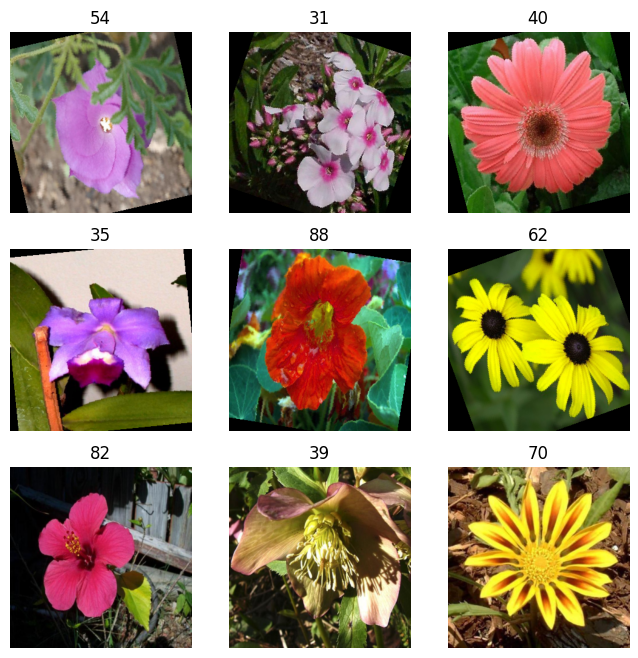

In [4]:
figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1,2,0))
plt.show()

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 200, kernel_size=(5,5), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(6, 6)),
            nn.BatchNorm2d(200),
            
            nn.Conv2d(200, 400, kernel_size=(5,5), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(8, 8)),
            nn.BatchNorm2d(400),
            
            nn.Flatten(),
    
            nn.Linear(10000, 4000),
            nn.ReLU(),
    
            nn.Linear(4000, 102)
        )
    
    def forward(self, x):
        #x = self.flatten(x)
        logits = self.layers(x)
        return logits

In [7]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Conv2d(3, 200, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(6, 6), stride=(6, 6), padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(200, 400, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(8, 8), stride=(8, 8), padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=10000, out_features=4000, bias=True)
    (10): ReLU()
    (11): Linear(in_features=4000, out_features=102, bias=True)
  )
)


In [8]:
def train_loop(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        total_loss += loss.item()
        #if batch % 200 == 0:
            #loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}    [{current:>5d}/{size:>5d}]")
    print(f"Avg train loss: {(total_loss/len(dataloader)):>8f}")

In [9]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
learning_rate = 2.2e-2
batch_size = 20
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1, weight_decay=0)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimiser)
    test_loop(test_dataloader, model, loss_fn)
    if (t % 3 == 0):
	    learning_rate *= 0.9
print("Done!")

Epoch 1
-------------------------------
Avg train loss: 1.880264
Test Error: 
 Accuracy: 55.7%, Avg loss: 1.734630 

Epoch 2
-------------------------------
Avg train loss: 0.625547
Test Error: 
 Accuracy: 62.5%, Avg loss: 1.447069 

Epoch 3
-------------------------------
Avg train loss: 0.279365
Test Error: 
 Accuracy: 64.4%, Avg loss: 1.453788 

Epoch 4
-------------------------------
Avg train loss: 0.146354
Test Error: 
 Accuracy: 69.7%, Avg loss: 1.253000 

Epoch 5
-------------------------------
Avg train loss: 0.087999
Test Error: 
 Accuracy: 71.6%, Avg loss: 1.206954 

Epoch 6
-------------------------------
Avg train loss: 0.060540
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.257661 

Epoch 7
-------------------------------


KeyboardInterrupt: 

In [ ]:
torch.save(model, "model.pth")